In [6]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
import json
import os
from modules.model import InstanceSegmentation
from modules.viz import viz_results, viz_origin_boxes_masks, viz_history

# Dataset

<table>
    <tbody>
        <tr>
            <td>Name</td>
            <td>Size</td>
            <td>Source</td>
        </tr>
        <tr>
            <td>WHU-Building-Dataset</td>
            <td>15 GB</td>
            <td>https://gpcv.whu.edu.cn/data/building_dataset.html</td>
        </tr>
        <tr>
            <td>Scraped Poznań images</td>
            <td>15 GB</td>
            <td>https://www.geoportal.gov.pl/</td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td>Total</td>
            <td>30 GB</td>
            <td></td>
        </tr>
    </tbody>
</table>

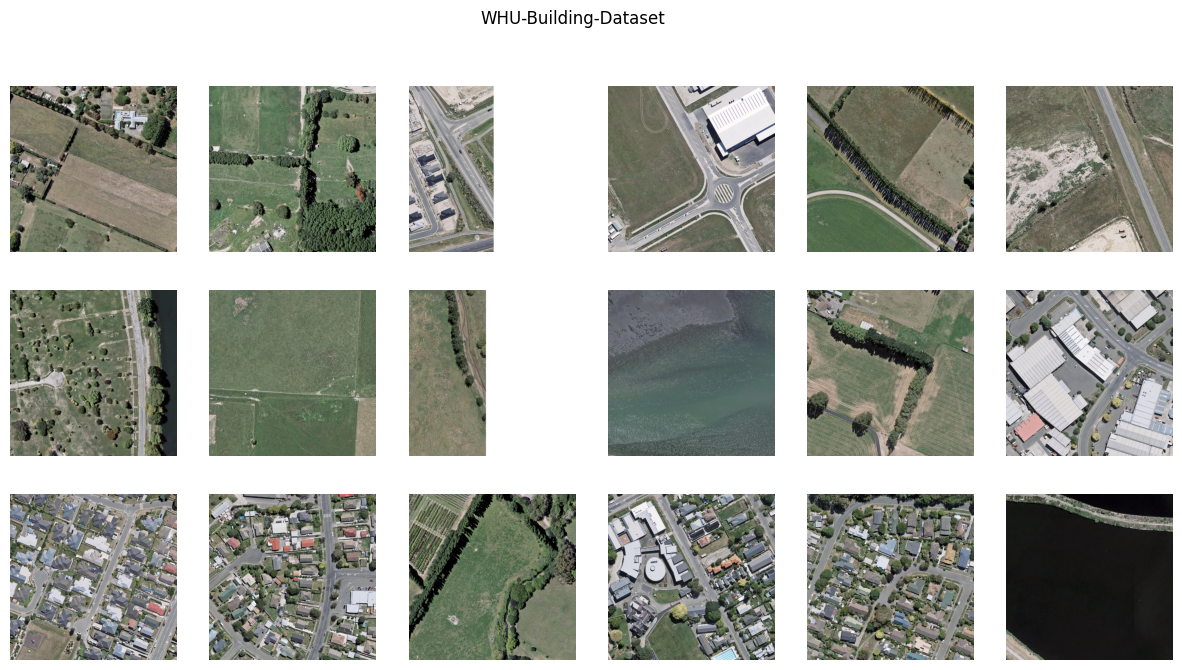

In [12]:
fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(15, 7.5))
imgs_paths = [
    f"./data/WHU-Building-Dataset/imgs/{img_name}" for img_name in
    np.random.choice(os.listdir("./data/WHU-Building-Dataset/imgs"), size=18)
]
for c in range(6):
    for r in range(3):
        img_path = imgs_paths[r*6 + c]
        img = Image.open(img_path)
        ax[r][c].imshow(img)
        ax[r][c].axis(False)

plt.suptitle("WHU-Building-Dataset")
plt.show()

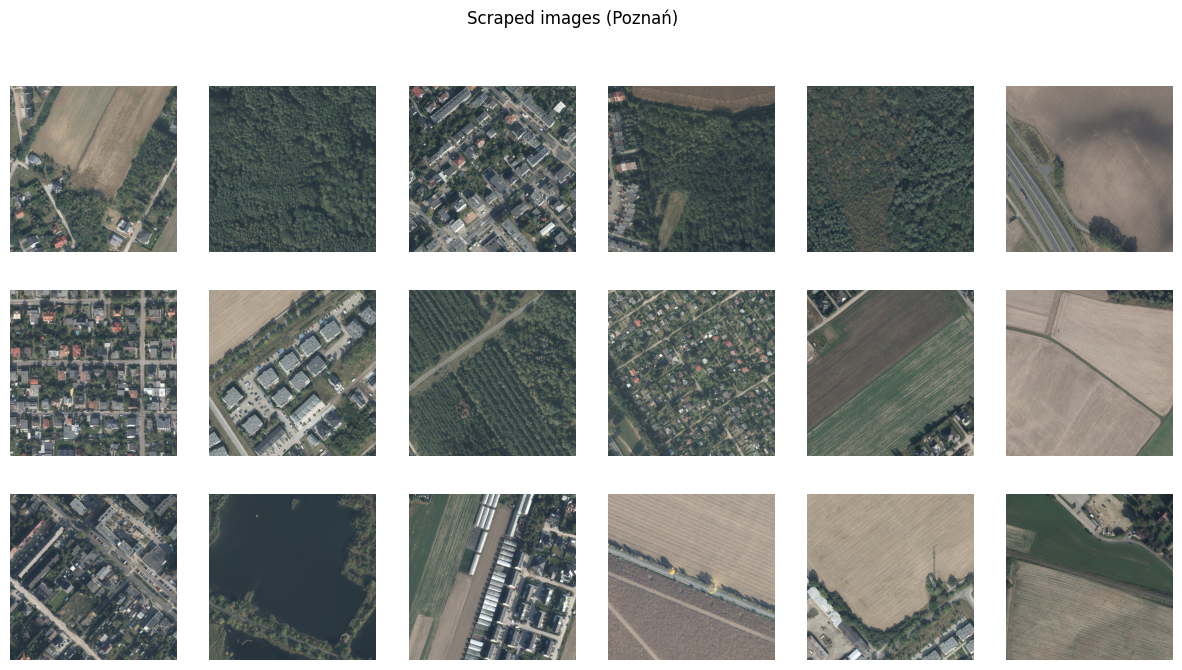

In [15]:
fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(15, 7.5))
imgs_paths = [
    f"./data/scraping/imgs/{img_name}" for img_name in
    np.random.choice(os.listdir("./data/scraping/imgs"), size=18)
]
for c in range(6):
    for r in range(3):
        img_path = imgs_paths[r*6 + c]
        img = Image.open(img_path)
        ax[r][c].imshow(img)
        ax[r][c].axis(False)

plt.suptitle("Scraped images (Poznań)")
plt.show()

# The problem

# Model

### Architecture

**Mask R-CNN** architecture proposed here https://arxiv.org/abs/1703.06870

<center>
    <img src="./docs/architecture.png" width="60%">
</center>

```python
class MaskDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(MaskDetector, self).__init__()
        
        # 1. Load Pretrained Backbone (ResNet50)
        backbone_base = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone_features = nn.Sequential(*list(backbone_base.children())[:-2])
        self.backbone_features.out_channels = 2048
        
        # 2. Define Anchor Generator
        anchor_sizes = ((32, 64, 128, 256, 512),) 
        aspect_ratios = ((0.5, 1.0, 2.0),)
        rpn_anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
        
        # 3. Define ROI Pooler for Boxes
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        
        # 4. Define ROI Pooler for Masks (New for Mask R-CNN)
        mask_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=14,
            sampling_ratio=2
        )
        
        # 5. Assemble Mask R-CNN
        self.model = MaskRCNN(
            self.backbone_features,
            num_classes=num_classes,
            rpn_anchor_generator=rpn_anchor_generator,
            box_roi_pool=box_roi_pool,
            mask_roi_pool=mask_roi_pool
        )

    def forward(self, images, targets=None):
        return self.model(images, targets)
```

### Size of model

Weight of the model: 672.197 MB

Parameters: 171 985 815

<table>
    <tbody>
        <tr>
            <td>Module</td>
            <td>Parameters</td>
        </tr>
        <tr>
            <td>Backbone</td>
            <td style="text-align: right">23 508 032</td>
        </tr>
        <tr>
            <td>RPN</td>
            <td style="text-align: right">37 904 459</td>
        </tr>
        <tr>
            <td>Box Head</td>
            <td style="text-align: right">103 821 322</td>
        </tr>
        <tr>
            <td>Mask Head</td>
            <td style="text-align: right">6 752 002</td>
        </tr>
    </tbody>
</table>

# Traning

Number of epochs: 4

Total learning time: ~4h

Command required to run traning: `python ./train.py`

# Metrics

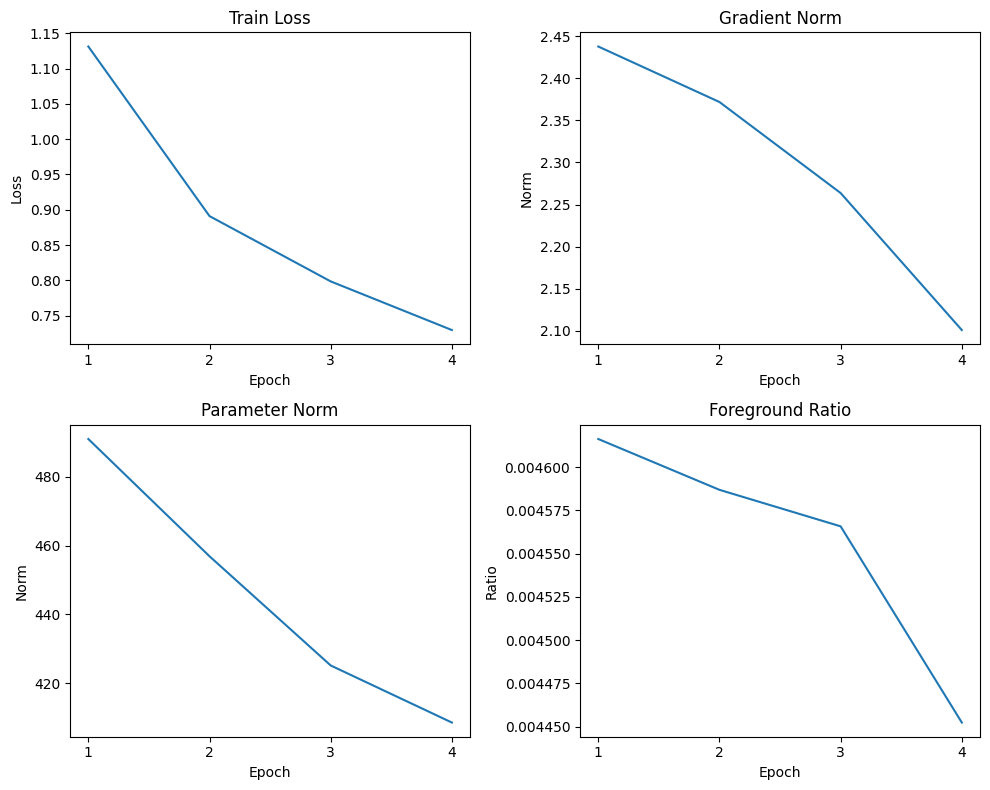

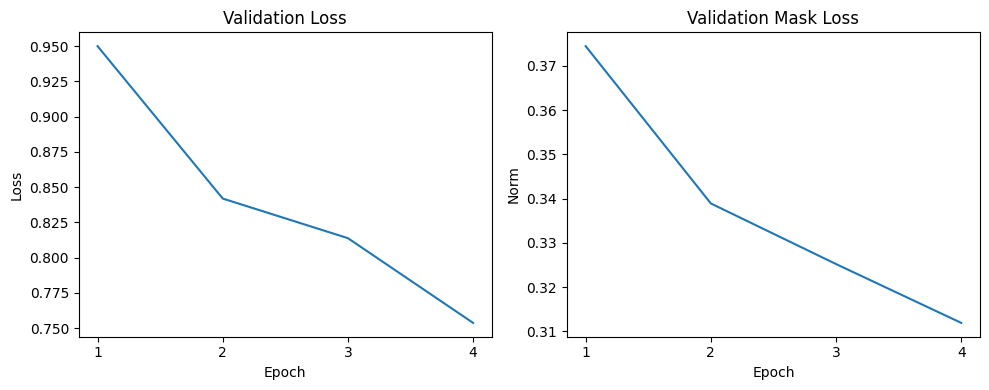

In [2]:
with open("./data/history.json", "r") as f:
    history = json.load(f)

viz_history(history)

### 1. Train Loss
Measures how well the model fits the training data by minimizing the sum of all task-specific losses (classification, box regression, mask, RPN). This is the objective optimized during training.  
$$
Loss_{\text{train}} = \sum_{i} \operatorname{mean}(Loss_i)
$$
```python
loss = sum(v.mean() for v in loss_dict.values())
```

### 2. Gradient Norm
Represents the overall magnitude of gradients across all model parameters and indicates optimization stability. Large values may signal exploding gradients, while very small values suggest vanishing gradients.  
<!-- $$
\|\nabla_{\theta} Loss\|_2 = \sqrt{\sum_{p \in \theta} \left\| \frac{\partial Loss}{\partial p} \right\|_2^2}
$$ -->
```python
grad_norm = torch.sqrt(sum(p.grad.norm(2)**2 for p in model.parameters() if p.grad is not None))
```

### 3. Parameter Norm
Measures the magnitude of model weights after an optimization step, reflecting how large the learned parameters are. It helps detect weight explosion or overly strong regularization.  
<!-- $$
\|\theta\|_2 = \sqrt{\sum_{p \in \theta} \|p\|_2^2}
$$ -->
```python
param_norm = torch.sqrt(sum(p.data.norm(2)**2 for p in model.parameters()))
```

### 4. Foreground Ratio (FG Ratio)
Describes the fraction of foreground (object) pixels in ground-truth masks, indicating dataset sparsity and class imbalance rather than model quality.  
$$
\text{FG Ratio} = \frac{\sum \mathbf{1}(m = 1)}{\sum \mathbf{1}}
$$
```python
fg_ratio = masks.float().mean()
```

### 5. Validation Loss
Computes the same total loss as training loss but on unseen validation data, measuring how well the model generalizes beyond the training set.  
$$
Loss_{\text{val}} = \sum_{i} \operatorname{mean}(Loss_i \mid \mathcal{D}_{\text{val}})
$$
```python
val_loss = sum(v.mean() for v in loss_dict.values())
```

### 6. Validation Mask Loss
Evaluates only the segmentation (mask) loss on validation data, isolating pixel-level mask quality independent of detection and classification performance.  
$$
Loss_{\text{mask,val}} = \operatorname{mean}(Loss_{\text{mask}} \mid \mathcal{D}_{\text{val}})
$$

```python
val_mask_loss = loss_dict["loss_mask"].mean()
```

# Hyperparameters

For traning we set learning rate scheduler:
```python
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
```
Initial learning rate is `0.005` and after each epoch learning rate is 2 time smaller.

# Runtime environment

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/Kaggle_Logo.svg" width="10%">

Our runtime evironment was Kaggle and GPU acceleration with NVIDIA T4.

# Example results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InstanceSegmentation()
checkpoint = torch.load("./models/instance_segmentation/instance_segmentation_4.pth", map_location=device)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()
pass

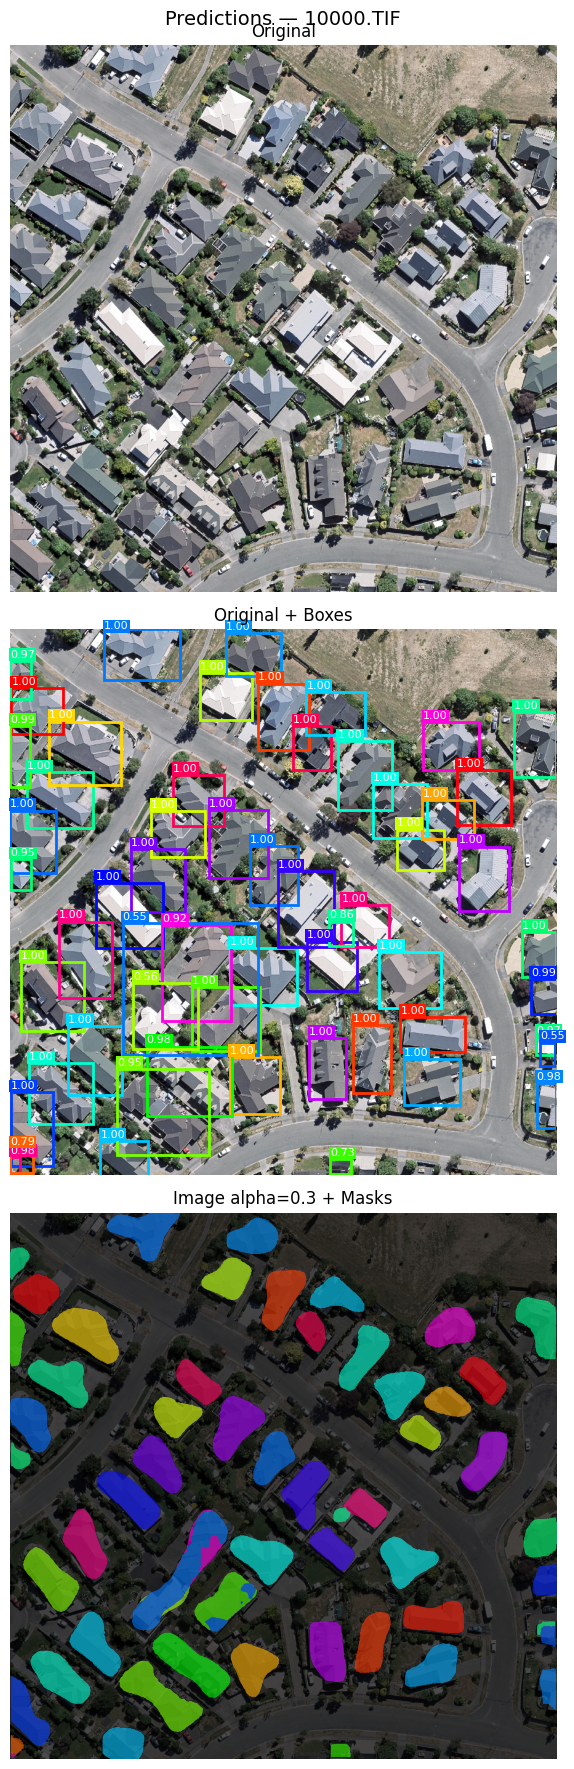

In [4]:
viz_origin_boxes_masks("./data/WHU-Building-Dataset/imgs/10000.TIF", model, device)

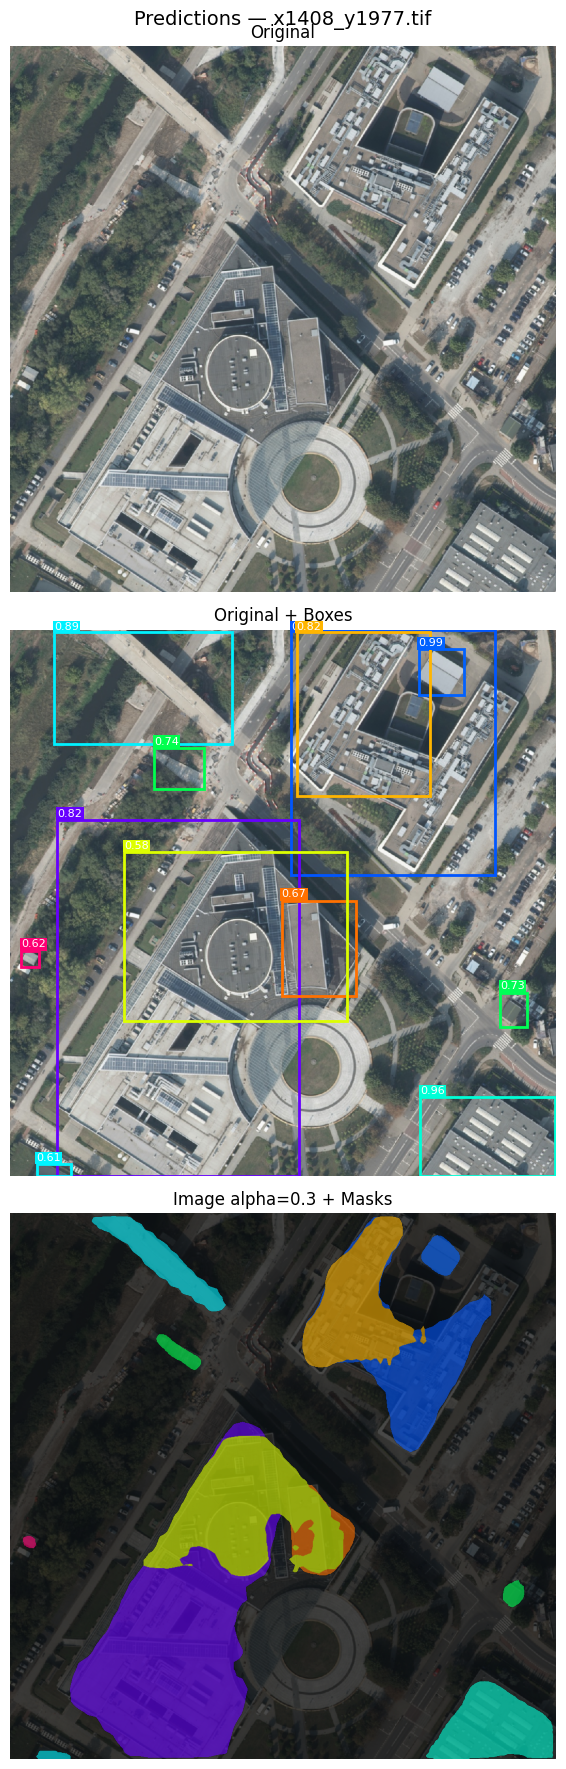

In [5]:
viz_origin_boxes_masks("./examples/imgs/x1408_y1977.tif", model, device)

# Completed Task

<table>
    <tbody>
        <tr>
            <td>Problem: Instance segmentation</td>
            <td>3pk.</td>
        </tr>
        <tr>
            <td>pre-trained model on the different problem (transfer-learning)</td>
            <td>1pk.</td>
        </tr>
        <tr>
            <td>Data (&gt;10000 photos and &gt;500 own phots)</td>
            <td>2pk.</td>
        </tr>
        <tr>
            <td>Adaptive hyperparameters</td>
            <td>1pk.</td>
        </tr>
        <tr>
            <td>Data augmentation</td>
            <td>1pk.</td>
        </tr>
        <tr>
            <td>Run as docker/ docker compose</td>
            <td>1pk.</td>
        </tr>
        <tr>
            <td>REST API or GUI for example Gradio, Streamlit</td>
            <td>1pk.</td>
        </tr>
        <tr>
            <td>DVC</td>
            <td>2pk.</td>
        </tr>
        <tr>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td>Sum</td>
            <td>12pk.</td>
        </tr>
    </tbody>
</table>

# References

### Data source:
- https://gpcv.whu.edu.cn/data/building_dataset.html

### Information sources:
- https://arxiv.org/abs/1703.06870
- https://arxiv.org/abs/1506.01497